In [1]:
import math
import time
import numpy as np
import torch

# 使用张量计算效率会比for高
n = 100000
a = torch.ones([n])
b = torch.ones([n])

class Timer:
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()
        
    def start(self):
        """启动计时器"""
        self.tik = time.time()
        
    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    
    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)
    
    def sum(self):
        """返回时间总和"""
        return sum(self.times)
    
    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

# 使用for逐个元素相加
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
print(f'{timer.stop():.5f} sec')

# 使用张量计算
timer.start()
d = a + b
print(f'{timer.stop():.5f} sec')

0.44268 sec
0.00033 sec


features: tensor([ 1.9378, -0.7822]) 
label: tensor([10.7184])


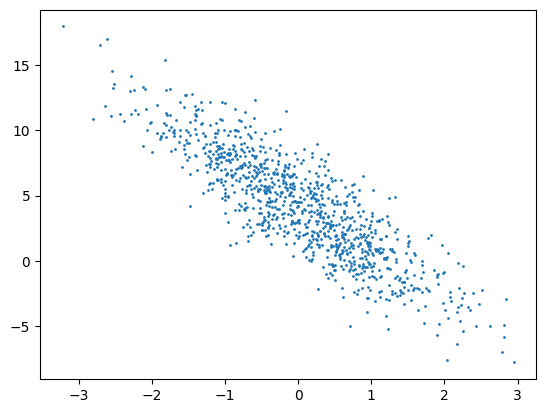

In [2]:
import random
import torch

def synthetic_data(w, b, num_examples):
    """生成y=Xw+b+噪声"""
    # 生成均值为0标准差为1， num_examples * len(w)大小的张量
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape) # 噪声
    return X, y.reshape((-1, 1))

# 使用w = [2, -3.4]和b = 4.2，以及噪声项ϵ，生成数据集和标签
# y = Xw + b + ϵ
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

print('features:', features[0],'\nlabel:', labels[0])

from matplotlib import pyplot as plt
plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)
# detach是为了分离张量的数值，减少内存开销，不加也可以

In [3]:
# 随机生成数据的函数
def data_iter(batch_size, features, labels):
    num_examples = len(features) # len仅返回第一个维度的大小
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size): # [0, num_examples)，步长为batch_size
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices] # 每次迭代时返回，而不是一次性返回
        
        
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.0284, -1.2337],
        [-0.0240, -0.2334],
        [-0.5405, -0.6218],
        [-0.9946,  0.2293],
        [ 1.2767, -0.3015],
        [ 0.0522, -1.1645],
        [-3.0741, -0.0261],
        [ 0.0734, -0.5409],
        [-1.6967,  1.1549],
        [ 1.2965,  0.1987]]) 
 tensor([[ 8.3509],
        [ 4.9362],
        [ 5.2429],
        [ 1.4322],
        [ 7.7769],
        [ 8.2495],
        [-1.8533],
        [ 6.1842],
        [-3.1127],
        [ 6.1325]])


In [4]:
# 尝试使用cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# 初始化权重
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
# w = torch.zeros((2,1)) 权重不能初始化为0，自动求导无法处理具有常数梯度的情况
b = torch.zeros(1, requires_grad=True)

# 定义模型
def linear_regression(X, w, b):
    # Y = Xw + b线性回归模型
    return torch.matmul(X, w) + b

# 定义损失函数
def squared_loss(y_hat, y):
    # 均方损失
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

# 定义优化算法
def sgd(params, lr, batch_size):
    # 小批量随机梯度下降，线性回归有解析解
    # with torch.no_grad()是为了禁用梯度计算，在更新参数的过程中不需要计算梯度
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            # 注意：尽管no_grad()禁用了梯度，但是with之外梯度计算仍然启用，所以每次更新参数后需要清除梯度
            param.grad.zero_() 

cuda


In [5]:
# 训练过程
lr = 0.03
num_epochs = 3
net = linear_regression
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size) # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
        
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

epoch 1, loss 0.035710
epoch 2, loss 0.000135
epoch 3, loss 0.000050
w的估计误差：tensor([ 0.0008, -0.0004], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0005], grad_fn=<RsubBackward1>)


In [6]:
# 线性回归的简洁实现
import numpy as np
import torch
from torch.utils import data

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

def load_array(data_arrays, batch_size, shuffle=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays) # 为了将元祖拆分为多个独立元素
    return data.DataLoader(dataset, batch_size, shuffle=shuffle)

In [7]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)
next(iter(data_iter))

[tensor([[-1.2668, -1.2655],
         [-1.0222,  0.6226],
         [ 1.0272,  0.1479],
         [ 0.5125,  0.4618],
         [-0.8919,  1.1850],
         [ 2.1543, -0.3307],
         [ 1.3397, -0.3240],
         [ 0.4561,  1.0964],
         [-0.7042, -1.9035],
         [ 0.6246, -0.5539]]),
 tensor([[ 5.9750],
         [ 0.0448],
         [ 5.7453],
         [ 3.6608],
         [-1.6068],
         [ 9.6398],
         [ 7.9539],
         [ 1.3895],
         [ 9.2612],
         [ 7.3294]])]

In [8]:
# 开始定义模型
from torch import nn
# nn.Sequential可以将多个层连接在一起
# nn.Linear为定义了线性层
net = nn.Sequential(nn.Linear(2, 1))

In [9]:
# 设定网络中权重初始值
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

# 定义损失函数
loss = nn.MSELoss()

# 定义优化算法
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [10]:
# 训练过程
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y) # 前向推理，计算损失
        # 反向传播前需要清除梯度，清除梯度过程也可以放在loss前
        trainer.zero_grad() # 清除梯度
        l.backward() # 反向传播
        trainer.step() # 根据反向传播梯度优化参数
    with torch.no_grad():
        # 在从零实现中，这里禁止了梯度，但是为何在简洁实现中禁止梯度是不必要的？
        l = loss(net(features), labels)
        print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000296
epoch 2, loss 0.000091
epoch 3, loss 0.000092


In [11]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)
# 因为误差函数有所差别，所以估计误差也会有差别

w的估计误差： tensor([-0.0004, -0.0014])
b的估计误差： tensor([-0.0008])
